# Pima indian diabetes

For Each Attribute: (all numeric-valued)
   1. Number of times pregnant/怀孕次数
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test/口服葡萄糖耐量测试中2小时内血糖浓度
   3. Diastolic blood pressure (mm Hg)/舒张压(毫米汞柱)
   4. Triceps skin fold thickness (mm)/三头肌褶皱厚度(mm)
   5. 2-Hour serum insulin (mu U/ml)/2小时血清胰岛素(mu U/ ml)
   6. Body mass index (weight in kg/(height in m)^2)/体质指数
   7. Diabetes pedigree function/糖尿病血统函数
   8. Age (years)/年龄
   9. Class variable (0 or 1)/诊断

Class Distribution: (class value 1 is interpreted as "tested positive for diabetes")


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

%matplotlib inline

# Regularized cost function

In [2]:
def logisticCostFunRegularized(theta, X, y, lam):
    [m, n] = X.shape
    theta = theta.reshape((n, 1))
    
    hypothesis = sigmoid(np.dot(X,theta))
    J = 1/m * (np.dot(-y.transpose(), np.log(hypothesis))-np.dot((1-y.transpose()), np.log(1-hypothesis)))+lam/(2*m)*np.dot(theta[1:].transpose(), theta[1:])
    
    grad0 = 1/m * np.dot(X.T.iloc[0].values.reshape(1, m), hypothesis - y)
    grad = 1/m * np.dot(X.T, hypothesis - y) + lam/m*theta
    grad[0] = grad0
    return(float(J), grad.flatten())

# Sigmoid function

In [3]:
def sigmoid(z):
    return(1/(1+np.e**(-z)))

# Feature normalization

In [4]:
# Feature normalization(FOR DATAFRAME, NOT NUMPY ARRAY)
def featureNormalize(X, mu = 0, sigma = 0):
    if((type(mu)==int or type(mu)== int) and (mu==0 or sigma==0)):
        mu = np.mean(X)
        sigma = np.std(X)
        XNorm = (X - mu)/sigma
        return(XNorm, mu, sigma)
    else:
        XNorm = (X - mu)/sigma
        return(XNorm)

# Regularized Gradient Descent

In [5]:
def gradientDescentRegularized(X, y, theta, alpha, num_iters, lam):
    m = len(y)
    JHistory = []
    for i in range(num_iters):
        hypothesis = sigmoid(np.dot(X,theta))
        tempTheta0 = theta[0] - alpha/m*np.dot(X.transpose().iloc[0,:], hypothesis[0]-y.iloc[:,0])
        
        theta = theta - alpha*(1/m*np.dot(X.transpose(), hypothesis-y) + lam/m*theta)
        JHistory.append(logisticCostFunRegularized(theta,X,y, lam)[0])
    return([theta, JHistory])

## scipy minimize function

In [6]:
#regression theta can be initialized to 0
def trainLinearReg(X, y, lam):
    theta = np.zeros((X.shape[1], 1))
    options={'disp': False, 'gtol': 1e-6} #'gtol':1e-6, 'maxIters': 50,     for BFGS
    minimizeArgs = (X, y, lam)
    res = minimize(logisticCostFunRegularized, theta, method='CG', jac=True, options=options,args=minimizeArgs) #, callback=append 
    return(res)

def append(x):
    JHistory.append(logisticCostFunRegularized(x, XTrain, yTrain, lam)[0])

## Misclassification error function

In [7]:
def misclassificationErrorFun(theta, X, y, threshold):
    m = y.shape[0]
    hypothesis = sigmoid(np.dot(X, theta))
    prediction = (hypothesis >= threshold) * 1
    prediction = prediction.reshape((1, prediction.shape[0]))
    testError = 1/m * np.sum(np.array(yTest[yTest.columns[0]]) != prediction)
    return(testError)

# prediction function

In [8]:
def predict(theta, X, y, threshold):
    prediction = (sigmoid(np.dot(XTest, theta)) >= threshold) * 1
    prediction = pd.DataFrame(prediction, index = y.index, columns=['prediction'])
    result = pd.concat([y, prediction], axis=1)
    accuracy = np.sum(y[y.columns[0]] == prediction['prediction'])/y.shape[0]
    return(result, accuracy)

## read files

In [9]:
data = pd.read_csv("pima-indians-diabetes.data.txt", names=['NoPregnant', 'Plasma glucose concentration', 'Diastolic blood pressure(mm Hg)', 'Triceps skin fold thickness (mm)', '2-hr serum insulin(mu U/ml)', 'Body mass index', 'Diabetes pedigree function', 'Age', 'Class variable'])
data.head()

,NoPregnant,Plasma glucose concentration,Diastolic blood pressure(mm Hg),Triceps skin fold thickness (mm),2-hr serum insulin(mu U/ml),Body mass index,Diabetes pedigree function,Age,Class variable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# separating sets and normalize

In [10]:
#xTrain, xCV, xTest
X = data[data.columns[:-1]]
y = pd.DataFrame(data[data.columns[-1]])
m = X.shape[0]

mTemp = np.round(X.shape[0]*0.4)
if mTemp%2 != 0:
    mTemp+=1
mCV = mTest = int(mTemp/2)
mTrain = int(m - mTemp)

XTrain = X.iloc[:mTrain]
yTrain = y.iloc[:mTrain]
XTrain, mu, sigma = featureNormalize(XTrain)
x0 = pd.DataFrame(np.ones((mTrain, 1)), columns=["x0"], index=XTrain.index)
XTrain=pd.concat([x0, XTrain], axis=1)

XCV = X.iloc[mTrain:mTrain+mCV]
yCV = y.iloc[mTrain:mTrain+mCV]
XCV = featureNormalize(XCV, mu, sigma)
x0 = pd.DataFrame(np.ones((mCV, 1)), columns=["x0"], index=XCV.index)
XCV=pd.concat([x0, XCV], axis=1)

XTest = X.iloc[-mCV:]
yTest = y.iloc[-mCV:]
XTest = featureNormalize(XTest, mu, sigma)
x0 = pd.DataFrame(np.ones((mTest, 1)), columns=["x0"], index=XTest.index)
XTest=pd.concat([x0, XTest], axis=1)

## scipy.optimize.minimize
### Find the best $\lambda$

In [11]:
lamVec = [0.0001, 0.0002, 0.0004, 0.0008, 0.0016, 0.032, 0.0064, 0.0128, 0.0256, 0.0512, 1.024, 2.048, 4.096, 8.192, 16.384]

In [12]:
CVCost = []
for i in range(len(lamVec)):
    lam = lamVec[i]
    theta = trainLinearReg(XTrain, yTrain, lamVec[i]).x
    CVCost.append(logisticCostFunRegularized(theta, XCV, yCV, 0)[0])
    print('lambda = ' + str(lamVec[i]) + ', CV cost: ' + str(CVCost[-1]))

lambda = 0.0001, CV cost: 0.4122746670438122
lambda = 0.0002, CV cost: 0.41227471953926365
lambda = 0.0004, CV cost: 0.4122748244693618
lambda = 0.0008, CV cost: 0.41227503411348915
lambda = 0.0016, CV cost: 0.41227545234731494
lambda = 0.032, CV cost: 0.4122910707279443
lambda = 0.0064, CV cost: 0.4122776803841297
lambda = 0.0128, CV cost: 0.41228115376573393
lambda = 0.0256, CV cost: 0.4122879126803875
lambda = 0.0512, CV cost: 0.4123017995379136
lambda = 1.024, CV cost: 0.41285656469399856
lambda = 2.048, CV cost: 0.41350881765141734
lambda = 4.096, CV cost: 0.4149588856393644
lambda = 8.192, CV cost: 0.4181761369841567
lambda = 16.384, CV cost: 0.4248915128415326


In [13]:
np.where(CVCost == np.min(CVCost))

(array([0]),)

best lambda = 0.0001  
### Then train $\theta$s on the best $\lambda$

In [14]:
lam = 0.0001
result = trainLinearReg(XTrain, yTrain, lam)
theta = result.x.reshape((XTrain.shape[1], 1))

## Gradient descent

In [15]:
initial_theta = np.zeros((XTrain.shape[1], 1))
alpha = 6
numIters = 20

CVCost = []
for i in range(len(lamVec)):
    thetaGD = gradientDescentRegularized(XTrain, yTrain, initial_theta, alpha, numIters, lamVec[i])[0]
    CVCost.append(logisticCostFunRegularized(thetaGD, XCV, yCV, 0)[0])
    print('lambda = ' + str(lamVec[i]) + ', CV cost: ' + str(CVCost[-1]))

lambda = 0.0001, CV cost: 0.41232202926870043
lambda = 0.0002, CV cost: 0.4123221753494607
lambda = 0.0004, CV cost: 0.41232246751377466
lambda = 0.0008, CV cost: 0.41232305185357754
lambda = 0.0016, CV cost: 0.4123242205778825
lambda = 0.032, CV cost: 0.41236867626026075
lambda = 0.0064, CV cost: 0.4123312341752659
lambda = 0.0128, CV cost: 0.412340588975793
lambda = 0.0256, CV cost: 0.4123593100184459
lambda = 0.0512, CV cost: 0.4123967978665395
lambda = 1.024, CV cost: 0.41386740169779856
lambda = 2.048, CV cost: 0.41552505764960346
lambda = 4.096, CV cost: 0.41942401205276425
lambda = 8.192, CV cost: 0.43681498719342055
lambda = 16.384, CV cost: 0.5104309328973068


In [16]:
np.where(CVCost == np.min(CVCost))

(array([0]),)

best lambda for GD = 0.0001

In [17]:
#params
lamGD = 0.0001
initial_theta = np.zeros((XTrain.shape[1], 1))
alpha = 6
numIters = 20 #400

thetaGD = gradientDescentRegularized(XTrain, yTrain, initial_theta, alpha, numIters, lamGD)[0]

# Theta from minimize and thetaGD from gradient descent comparison

In [18]:
theta

array([[-0.68501277],
       [ 0.35696294],
       [ 1.08952824],
       [-0.12461744],
       [ 0.00237897],
       [-0.20344015],
       [ 0.72951897],
       [ 0.33800241],
       [ 0.10591689]])

In [19]:
thetaGD

array([[-0.6852041 ],
       [ 0.35741233],
       [ 1.08926623],
       [-0.12486035],
       [ 0.00126292],
       [-0.20449152],
       [ 0.72898456],
       [ 0.33773162],
       [ 0.10640696]])

# Test set error:
describes how accurate the model is generalizing. __Use $\lambda = 0$__

In [20]:
cost = logisticCostFunRegularized(theta, XTest, yTest, 0)[0]
costGD = logisticCostFunRegularized(thetaGD, XTest, yTest, 0)[0]
print('cost: '+ str(cost))
print('costGD: ' + str(costGD))

cost: 0.4850783297513151
costGD: 0.4849731080685893


## make predictions and select best prediction threshold

### for theta from minimize

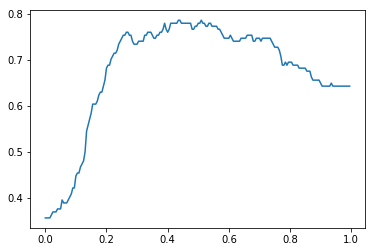

In [21]:
thresholdVec = np.arange(0,1, 0.005)
accuracyVec = []
for i in range(len(thresholdVec)):
    accuracyVec.append(predict(theta, XTest, yTest, thresholdVec[i])[1])
plt.plot(thresholdVec, accuracyVec)
t = accuracyVec

In [22]:
thresholdVec[np.where(accuracyVec == np.max(accuracyVec))]

array([ 0.435,  0.44 ,  0.51 ])

### theta from gradient descent

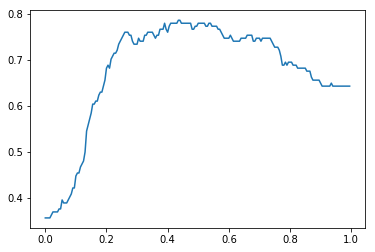

In [23]:
thresholdVec = np.arange(0,1, 0.005)
accuracyVec = []
for i in range(len(thresholdVec)):
    accuracyVec.append(predict(thetaGD, XTest, yTest, thresholdVec[i])[1])
plt.plot(thresholdVec, accuracyVec)

In [24]:
thresholdVec[np.where(accuracyVec == np.max(accuracyVec))]

array([ 0.435,  0.44 ])

### misclassification value

In [25]:
threshold = 0.435
gdThreshold = 0.435
misclassificationErrorFun(theta, XTest, yTest, threshold)

0.2142857142857143

In [26]:
threshold = 0.435
gdThreshold = 0.435
misclassificationErrorFun(thetaGD, XTest, yTest, threshold)

0.2142857142857143

prediction accuracy

In [27]:
result, accuracy = predict(theta, XTest,yTest, threshold)
accuracy

0.7857142857142857

In [28]:
GDresult, GDaccuracy = predict(thetaGD, XTest,yTest, gdThreshold)
GDaccuracy

0.7857142857142857

In [29]:
def learningCurve(X,y,Xval,yval, lam, subsetSize):

    errorTrain = np.zeros((subsetSize,1))
    errorVal = np.zeros((subsetSize,1))
    
    for i in range(1, subsetSize + 1):
        theta = trainLinearReg(X.iloc[:i, :], y.iloc[:i], lam).x
        errorTrain[i-1] = logisticCostFunRegularized(theta, X.iloc[:i, :], y.iloc[:i], 0)[0]
        errorVal[i-1] = logisticCostFunRegularized(theta, Xval, yval, 0)[0]
    return({'errorTrain': errorTrain, 'errorVal':errorVal})

Text(0,0.5,'cost')

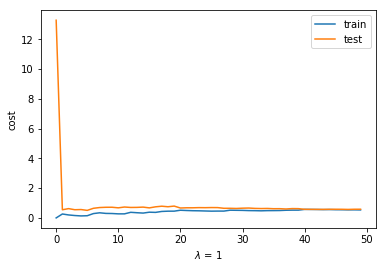

In [30]:
subsetSize = 50
errors = learningCurve(XTrain, yTrain, XTest, yTest, 1, subsetSize);
errorTrain = errors['errorTrain']
errorVal = errors['errorVal']
    
plt.plot(range(subsetSize), errorTrain, label="train")
plt.plot(range(subsetSize), errorVal, label="test")
plt.legend(loc=0)
plt.xlabel('$\lambda$ = 1')
plt.ylabel('cost')